<a href="https://colab.research.google.com/github/dtoumoula/GEE-Image-Analysis-API/blob/main/Traitement_Et_Analyse_Images_Satellites_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traitement et Analyse d'Images Satellites avec Google Earth Engine & Python

Ce projet vise à télécharger, prétraiter et analyser des images satellites Sentinel-2 sur une zone donnée.  
Objectifs :
- Débruitage pixel par pixel
- Redimensionnement
- Amélioration du contraste
- Extraction de caractéristiques
- Détection de maisons

- Analyse textuelle géolocalisée

Zone d’étude : **Lomé, Togo**  
Période : **janvier 2018 à août 2025**

#### **Installation des Bibliothèques**

Ce notebook a pour objectif d'extraire une image satellite depuis Google Earth Engine (GEE) en utilisant une fonction Python réutilisable.

La première étape consiste à installer les bibliothèques nécessaires :

**earthengine-api** : Pour communiquer avec les serveurs de GEE.
**geemap** : Une bibliothèque très pratique pour visualiser les données de GEE de manière interactive dans un notebook.

Nous allons exécuter ces installations dans la cellule de code suivante.

In [ ]:
!pip install -q earthengine-api geemap rasterio folium opencv-python eo-learn s2cloudless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.

`ee`: API Google Earth Engine

`os`: Fournit un moyen d'utiliser les fonctionnalités dépendantes du système d'exploitation

`OpenCV(cv2)`  Bibliothèque OpenCV pour le traitement d'images (par exemple, pour le filtre médian)

`glob`  Trouve tous les noms de chemin correspondant à un motif spécifié

`geemap` Bibliothèque pour la cartographie interactive avec GEE

 folium # Bibliothèque pour créer des cartes interactives

 `datetime` Fournit des classes pour manipuler les dates et les heures

`rasterio` Bibliothèque pour lire et écrire des données raster géospatiales

`numpy` Bibliothèque pour les opérations numériques, en particulier avec les tableaux

`pandas` Bibliothèque pour la manipulation et l'analyse de données

`from rasterio.plot import show`  Fonction pour afficher les données raster

`from google.colab import drive`: Monte Google Drive pour accéder aux fichiers

`import matplotlib.pyplot as plt`:Bibliothèque pour créer des visualisations

`from scipy.ndimage import median_filter`: Fonction de filtre médian de SciPy

`from google.colab.patches import cv2_imshow`: Fonction pour afficher les images OpenCV dans Colab

In [ ]:
import ee
import os
import cv2
import glob
import geemap
import folium
import datetime
import rasterio
import numpy as np
import pandas as pd
from rasterio.plot import show
from google.colab import drive
import matplotlib.pyplot as plt
from rasterio.windows import Window
from sklearn.cluster import MiniBatchKMeans
from google.colab.patches import cv2_imshow
from s2cloudless import S2PixelCloudDetector
from rasterio.warp import reproject, Resampling
from skimage.restoration import denoise_wavelet
from skimage.feature import graycomatrix, graycoprops
from scipy.ndimage import median_filter, gaussian_filter
from skimage.restoration import denoise_wavelet, denoise_bilateral

### **Authentification et Initialisation de GEE**

Maintenant que les bibliothèques sont installées, nous devons authentifier notre session Colab pour lui donner accès à notre compte Google Earth Engine.

L'exécution de la cellule suivante va :

Vous demander de vous connecter à votre compte Google et d'autoriser l'accès.

Vous fournir un code d'autorisation que vous devrez copier.

Coller ce code dans le champ de saisie qui apparaît dans la sortie de la cellule Colab et appuyer sur Entrée.

Une fois l'authentification réussie, nous initialiserons l'API.

In [ ]:
# Authentification pour se connecter à la page web GEE
ee.Authenticate()

# Initialisation de notre projet créer sur GEE
ee.Initialize(project='satimageanalyze')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


AVAnt de exporter l'images, les nuages onjt ete nettoyer depuis GEE

In [ ]:
# Zone d'intérêt(AOI)

zone_interet = ee.Geometry.Polygon([[
    [1.159, 6.117], [1.159, 6.233],
    [1.350, 6.233], [1.350, 6.117],
    [1.159, 6.117]
]])

date_debut = '2018-01-01'
date_fin = '2025-01-01'
dossier_drive = 'Export_Lome_Serie_Temporelle'
SEUIL_PROBA_NUAGE = 50
bandes_a_exporter = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']



print(" Démarrage du processus de nettoyage et d'exportation ")


# Fonction pour masquer les nuages
def masquer_nuages_s2(image):
    probabilite_nuage = ee.Image(image.get('cloud_probability')).select('probability')
    isNotCloud = probabilite_nuage.lt(SEUIL_PROBA_NUAGE)
    return image.updateMask(isNotCloud)



#  Charger, filtrer et joindre les collections
collection_sr = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                 .filterBounds(zone_interet)
                 .filterDate(date_debut, date_fin))
collection_cloud_prob = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
                         .filterBounds(zone_interet)
                         .filterDate(date_debut, date_fin))
join_filter = ee.Filter.equals(leftField='system:index', rightField='system:index')
join = ee.Join.saveFirst('cloud_probability')
collection_jointe = ee.ImageCollection(join.apply(collection_sr, collection_cloud_prob, join_filter))


#  Appliquer le masque de nuage à toute la collection
collection_sans_nuages = collection_jointe.map(masquer_nuages_s2)


# Compter les images et interagir avec l'utilisateur
nombre_total = collection_sans_nuages.size().getInfo()
print(f"\n{nombre_total} images trouvées dans la période.")

if nombre_total > 0:

    # DÉBUT DE LA PARTIE INTERACTIVE
    nombre_a_exporter = 0
    while True:
        try:

            # Demander à l'utilisateur combien d'images exporter
            reponse = input(f"Combien des {nombre_total} images (les plus claires) voulez-vous exporter ? (Entrez un nombre, ou 0 pour annuler) ")
            nombre_a_exporter = int(reponse)

            if 0 <= nombre_a_exporter <= nombre_total:
                break # Sortir de la boucle si la réponse est valide
            else:
                print(f"Veuillez entrer un nombre entre 0 et {nombre_total}.")
        except ValueError:
            print("Entrée invalide. Veuillez entrer un nombre entier.")


    #  4. Lancer les exportations
    if nombre_a_exporter > 0:
        print(f"\nPréparation de l'exportation des {nombre_a_exporter} images les plus claires")

        # Trier la collection par couverture nuageuse et la convertir en liste
        liste_images = collection_sans_nuages.sort('CLOUDY_PIXEL_PERCENTAGE').toList(nombre_a_exporter)

        for i in range(nombre_a_exporter):
            image = ee.Image(liste_images.get(i))

            # Créer le nom de fichier
            date_str = image.date().format('YYYY-MM-dd').getInfo()
            nom_fichier = f"Lome_{date_str}_Nettoye"

            # Définir la tâche d'exportation
            tache_export = ee.batch.Export.image.toDrive(
                image=image.clip(zone_interet).select(bandes_a_exporter).toInt16(),
                description=nom_fichier,
                folder=dossier_drive,
                fileNamePrefix=nom_fichier,
                region=zone_interet,
                scale=10,
                crs='EPSG:32631',
                maxPixels=1e13
            )

            # Démarrer la tâche
            tache_export.start()
            print(f"  ({i+1}/{nombre_a_exporter}) Tâche d'exportation lancée pour : {nom_fichier}")

        print(f"\n{nombre_a_exporter} tâche(s) d'exportation ont été lancées.")
        print("Suivez leur progression ici : https://code.earthengine.google.com/tasks")
    else:
        print("\n Exportation annulée par l'utilisateur.")

else:
    print("Aucune image à exporter.")

 Démarrage du processus de nettoyage et d'exportation 

881 images trouvées dans la période.
Combien des 881 images (les plus claires) voulez-vous exporter ? (Entrez un nombre, ou 0 pour annuler) 3

Préparation de l'exportation des 3 images les plus claires
  (1/3) Tâche d'exportation lancée pour : Lome_2023-12-14_Nettoye
  (2/3) Tâche d'exportation lancée pour : Lome_2024-02-07_Nettoye
  (3/3) Tâche d'exportation lancée pour : Lome_2018-12-25_Nettoye

3 tâche(s) d'exportation ont été lancées.
Suivez leur progression ici : https://code.earthengine.google.com/tasks


## Nous définissons le chemin vers nos images

### **Paramètres, Exécution et Exportation Interactive**

C'est ici que tout se met en place ! Dans la cellule suivante :

Nous définissons nos paramètres de recherche (zone, dates, collection) et le nom du dossier de destination dans Google Drive.

- Nous appelons la fonction rechercher_images_gee pour obtenir la collection et le nombre d'images.

- Si des images sont trouvées, le script vous demandera combien vous souhaitez en exporter.

- Il lancera ensuite une boucle pour démarrer une tâche d'exportation pour chaque image demandée, en commençant par les moins nuageuses. Les fichiers seront sauvegardés au format GeoTIFF.

Ces images contiennent
 les bandes suivantes:

`['B2', 'B3', 'B4', 'B8', 'B11', 'B12']`

Voici pourquoi chaque groupe de bandes est indispensable :
1. Le Socle de Base : Visualisation et Végétation

`B4 (Rouge), B3 (Vert), B2 (Bleu)` : Le Contexte Visuel

**Role**: Indispensable pour créer une image en couleurs naturelles. Cela vous permet de vous orienter, de valider visuellement vos résultats et de comprendre la scène. Sans ce trio, vous travaillez à l'aveugle.

`B8 (Proche Infrarouge - NIR)` : Le Grand Séparateur

**Rôle** : C'est la bande la plus importante pour isoler la végétation de tout le reste. Le contraste entre la forte réflectance de la végétation en NIR et la faible réflectance des matériaux urbains est la base de la cartographie de l'étalement urbain (qui se fait souvent au détriment des espaces verts).

2. Les Bandes Clés pour l'Urbain : Les Révélateurs de Matériaux

C'est ici que se trouve la vraie puissance pour l'analyse urbaine. Les bandes Infrarouges à Ondes Courtes (SWIR) sont sensibles à la composition des matériaux et à la teneur en humidité.

`B11 (SWIR 1) et B12 (SWIR 2)` : Les Spécialistes des Surfaces Artificielles

**Rôle** : Ces bandes vous permettent de faire ce que le visible et le NIR ne peuvent pas faire :

**Différencier les surfaces imperméables** : Le béton, l'asphalte et les différents types de toitures n'ont pas la même signature spectrale dans le SWIR.

**Distinguer les sols nus des zones bâties**: Un sol sec et une route en béton peuvent se ressembler dans le visible, mais ils se distinguent beaucoup mieux dans le SWIR.

**Calculer des indices d'urbanisation** : Ces bandes sont les ingrédients principaux des indices conçus spécifiquement pour détecter les zones bâties.


L'avantage est que si nous exportons plus tard d'autres images dans un dossier différent, nous n'aurons qu'à appeler cette même fonction en lui donnant le nouveau nom de dossier

Important : L'exportation n'est pas instantanée. Elle s'exécute en arrière-plan sur les serveurs de Google. Nous pouvons suivre la progression des tâches dans la sortie de la cellule ou sur l'onglet *Tasks* de l'interface web de GEE.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Étape 2 : DÉFINITION DE LA FONCTION DE VISUALISATION ---

def afficher_images(chemin_image_geotiff):
    """
    Ouvre un fichier GeoTIFF Sentinel-2 et l'affiche en couleurs naturelles (RGB)
    avec un contraste amélioré pour une meilleure visualisation.

    Args:
        chemin_image_geotiff (str): Le chemin complet vers le fichier .tif.
    """
    nom_fichier = os.path.basename(chemin_image_geotiff)
    print(f"Préparation de l'affichage pour : {nom_fichier} ")

    #  Vérification et Lecture de l'image
    try:
        with rasterio.open(chemin_image_geotiff) as src:
            # On s'assure que l'image contient au moins les 3 bandes RGB
            if src.count < 3:
                print(f"ERREUR : L'image doit contenir au moins 3 bandes (Rouge, Vert, Bleu).")
                return

            # Lecture des bandes B4 (Rouge), B3 (Vert), et B2 (Bleu)
            # Les indices sont 3, 2, 1 car c'est l'ordre de votre export GEE.
            bande_rouge = src.read(3).astype(float)
            bande_verte = src.read(2).astype(float)
            bande_bleue = src.read(1).astype(float)

    except FileNotFoundError:
        print(f"ERREUR : Le fichier '{chemin_image_geotiff}' n'a pas été trouvé.")
        print("Veuillez vérifier le chemin et que votre Google Drive est bien monté.")
        return
    except Exception as e:
        print(f"Une erreur est survenue lors de la lecture du fichier : {e}")
        return

    #  Préparation des données pour l'affichage
    # 1. Remplacer les pixels nuls (anciens nuages, valeur 0) par NaN
    bande_rouge[bande_rouge == 0] = np.nan
    bande_verte[bande_verte == 0] = np.nan
    bande_bleue[bande_bleue == 0] = np.nan

    # 2. Empiler les 3 bandes pour former une image RGB
    image_rgb_brute = np.dstack((bande_rouge, bande_verte, bande_bleue))

    # 3. Améliorer le contraste pour que l'image ne soit pas trop sombre
    # Cette étape est purement VISUELLE et n'altère pas les données pour l'analyse.
    p2, p98 = np.nanpercentile(image_rgb_brute, (2, 98))
    image_rgb_affichee = (image_rgb_brute - p2) / (p98 - p2)
    image_rgb_affichee = np.clip(image_rgb_affichee, 0, 1)
    image_rgb_affichee[np.isnan(image_rgb_affichee)] = 0 # Afficher les zones masquées en noir

    # Affichage final
    print("Affichage de l'image...")
    plt.figure(figsize=(12, 12)) # Créer une grande figure pour les détails
    plt.imshow(image_rgb_affichee)
    plt.title(f'Image en Couleurs Naturelles\n{nom_fichier}', fontsize=16)
    plt.axis('off') # Cacher les axes (x, y)
    plt.show()

Préparation de l'affichage pour : Lome_2018-12-25_Nettoye.tif 
Affichage de l'image...


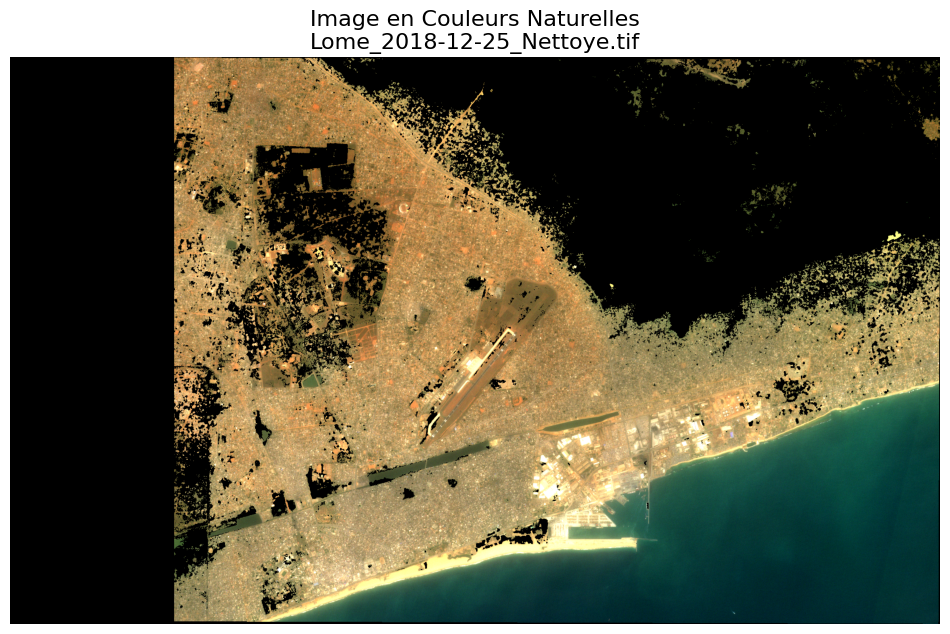

In [ ]:
# Étape 3 : EXEMPLE D'UTILISATION DE LA FONCTION

# Définissez le chemin vers le dossier où se trouvent vos images nettoyées
dossier_images = '/content/drive/My Drive/Export_Lome_Serie_Temporelle'

# Choisissez le nom d'une image que vous avez exportée
nom_image = 'Lome_2018-12-25_Nettoye.tif' # Remplacez par un de vos noms de fichier

# Construire le chemin complet
chemin_image_a_tester = os.path.join(dossier_images, nom_image)

# Appeler la fonction !
afficher_images(chemin_image_a_tester)

# Vous pouvez facilement l'appeler pour une autre image
# nom_autre_image = 'Lome_2025-01-22_Nettoye.tif'
# chemin_autre_image = os.path.join(dossier_images, nom_autre_image)
# afficher_couleurs_naturelles(chemin_autre_image)

Préparation de l'affichage pour : Lome_2023-12-14_Nettoye.tif 
Affichage de l'image...


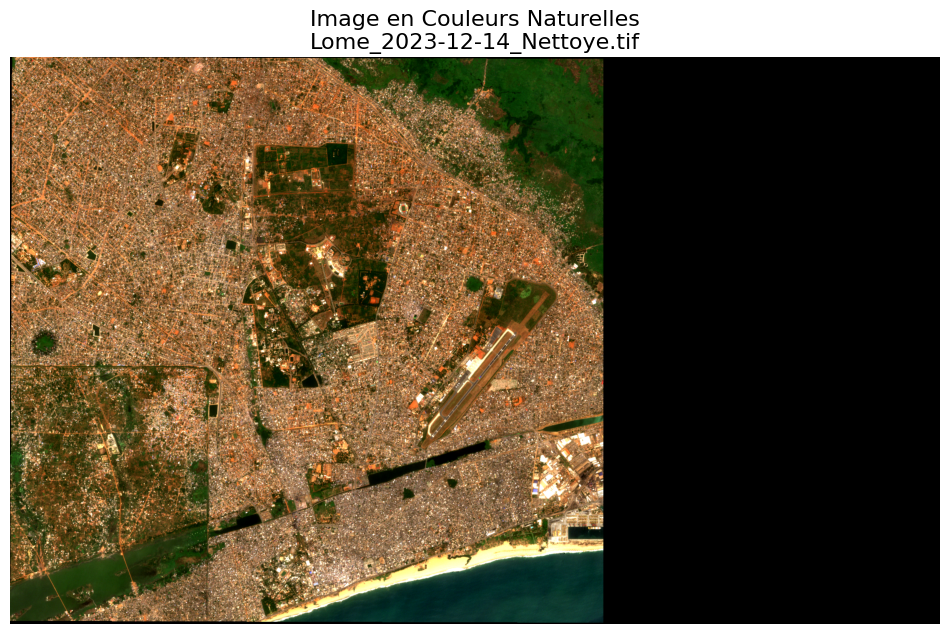

In [ ]:
#  EXEMPLE D'UTILISATION DE LA FONCTION

# Définissez le chemin vers le dossier où se trouvent vos images nettoyées
dossier_images = '/content/drive/My Drive/Export_Lome_Serie_Temporelle'

# Choisissez le nom d'une image que vous avez exportée
nom_image = 'Lome_2023-12-14_Nettoye.tif' # Remplacez par un de vos noms de fichier

# Construire le chemin complet
chemin_image_a_tester = os.path.join(dossier_images, nom_image)

# Appeler la fonction !
afficher_images(chemin_image_a_tester)

# Vous pouvez facilement l'appeler pour une autre image
# nom_autre_image = 'Lome_2025-01-22_Nettoye.tif'
# chemin_autre_image = os.path.join(dossier_images, nom_autre_image)
# afficher_couleurs_naturelles(chemin_autre_image)

Préparation de l'affichage pour : Lome_2024-02-07_Nettoye.tif 
Affichage de l'image...


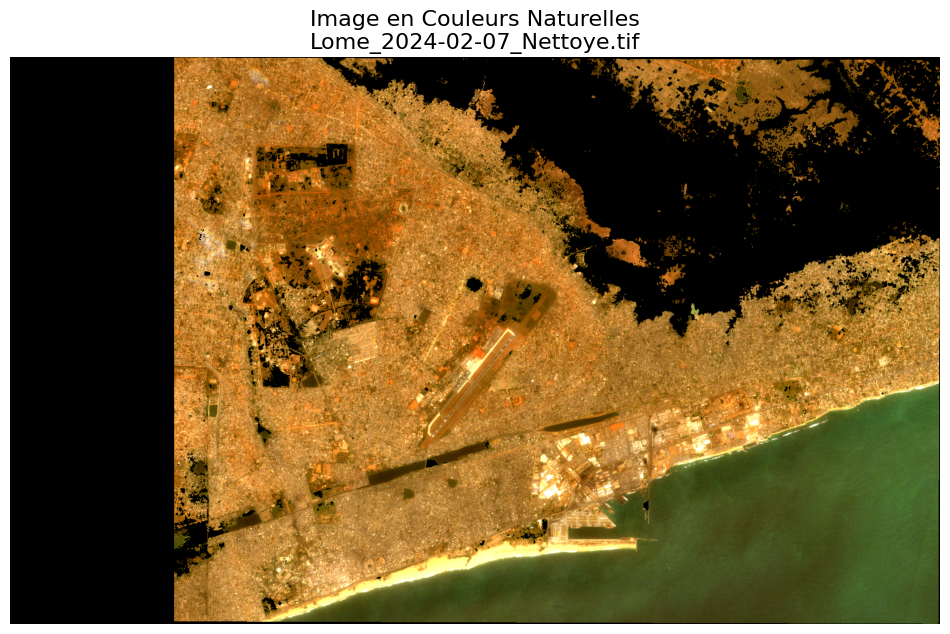

In [ ]:
#  EXEMPLE D'UTILISATION DE LA FONCTION

# Définissez le chemin vers le dossier où se trouvent vos images nettoyées
dossier_images = '/content/drive/My Drive/Export_Lome_Serie_Temporelle'

# Choisissez le nom d'une image que vous avez exportée
nom_image = 'Lome_2024-02-07_Nettoye.tif' # Remplacez par un de vos noms de fichier

# Construire le chemin complet
chemin_image_a_tester = os.path.join(dossier_images, nom_image)

# Appeler la fonction !
afficher_images(chemin_image_a_tester)

# Vous pouvez facilement l'appeler pour une autre image
# nom_autre_image = 'Lome_2025-01-22_Nettoye.tif'
# chemin_autre_image = os.path.join(dossier_images, nom_autre_image)
# afficher_couleurs_naturelles(chemin_autre_image)

In [ ]:
# LA FONCTION DE RECADRAGE

def supprimer_pixels_nuls_robust(image_entree_path, image_sortie_path):
    """
    Recadre une image en supprimant les bordures où TOUTES les bandes ont des pixels de valeur 0.
    Cette fonction est basée sur la logique fournie par l'utilisateur.

    Args:
        image_entree_path (str): Chemin vers l'image originale.
        image_sortie_path (str): Chemin où sauvegarder l'image recadrée.

    Returns:
        bool: True en cas de succès, False en cas d'échec.
    """
    try:
        with rasterio.open(image_entree_path) as src:

            # Lire toutes les bandes de l'image
            img = src.read()


            # Créer un masque où toutes les bandes sont à 0
            # np.all(..., axis=0) vérifie le long de l'axe des bandes (axe 0)
            zero_mask = np.all(img == 0, axis=0)

            # Inverser le masque pour trouver les pixels valides
            # Un pixel est valide si AU MOINS UNE de ses bandes n'est pas à 0
            valid_mask = ~zero_mask

            # Trouver les coordonnées des pixels valides
            rows, cols = np.nonzero(valid_mask)

            # Vérifier s'il y a des données valides
            if rows.size == 0:
                print(f"  AVERTISSEMENT : L'image {os.path.basename(image_entree_path)} est entièrement nulle. Fichier ignoré.")
                return False

            # Déterminer la fenêtre de recadrage
            min_row, max_row = rows.min(), rows.max()
            min_col, max_col = cols.min(), cols.max()

            window = Window(min_col, min_row, max_col - min_col + 1, max_row - min_row + 1)

            # Mettre à jour les métadonnées pour l'image de sortie
            transform = src.window_transform(window)
            profile = src.profile
            profile.update({
                'height': window.height,
                'width': window.width,
                'transform': transform,
                'nodata': src.nodata
            })

            # Lire les données recadrées et sauvegarder
            cropped_data = src.read(window=window)

            with rasterio.open(image_sortie_path, 'w', **profile) as dst:
                dst.write(cropped_data)

            return True

    except Exception as e:
        print(f" ERREUR lors du traitement de {os.path.basename(image_entree_path)} : {e}")
        return False

In [ ]:
#  LA FONCTION PRINCIPALE QUI PARCOURT NOTRE LISTE D'IMAGES
def recadrer_images_de_liste(liste_chemins_images, dossier_sortie_drive):
    """
    Parcourt une liste de chemins d'images, applique le recadrage robuste à chacune,
    et sauvegarde les résultats dans un dossier de sortie.

    Args:
        liste_chemins_images (list): Liste des chemins complets vers les images à traiter.
        dossier_sortie_drive (str): Nom du dossier dans "My Drive" où sauvegarder les images recadrées.
    """
    # Construire le chemin complet du dossier de sortie
    chemin_sortie = os.path.join('/content/drive/My Drive', dossier_sortie_drive)

    print(f"Lancement du Recadrage Robuste sur une Liste d'Images")
    print(f"Dossier de sortie : {chemin_sortie}\n")

    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(chemin_sortie, exist_ok=True)

    if not liste_chemins_images:
        print("La liste d'images fournie est vide.")
        return

    print(f"{len(liste_chemins_images)} image(s) à traiter.\n")

    fichiers_reussis = 0
    # Boucler sur chaque chemin d'image dans la liste
    for i, entree_path in enumerate(liste_chemins_images):
        nom_fichier = os.path.basename(entree_path)
        print(f"Traitement {i+1}/{len(liste_chemins_images)} : {nom_fichier}")

        # S'assurer que le fichier d'entrée existe avant de continuer
        if not os.path.exists(entree_path):
            print(f"ERREUR : Le fichier {nom_fichier} est introuvable. Fichier ignoré.")
            continue

        # Définir le chemin de sortie
        sortie_path = os.path.join(chemin_sortie, f"Re_{nom_fichier}")

        # Appeler la fonction de recadrage
        succes = supprimer_pixels_nuls_robust(entree_path, sortie_path)

        if succes:
            print(f"   Succès. Sauvegardé sous : Re_{nom_fichier}")
            fichiers_reussis += 1

    print(f"\n Traitement terminé ")
    print(f"{fichiers_reussis} sur {len(liste_chemins_images)} image(s) ont été recadrées avec succès.")


In [ ]:

liste_images_a_recadrer = [
            '/content/drive/My Drive/Export_Lome_Serie_Temporelle/Lome_2023-12-14_Nettoye.tif',
            '/content/drive/My Drive/Export_Lome_Serie_Temporelle/Lome_2024-02-07_Nettoye.tif',
            '/content/drive/My Drive/Export_Lome_Serie_Temporelle/Lome_2018-12-25_Nettoye.tif' ]


# Spécifiez le nom du dossier où vous voulez sauvegarder les résultats
nom_dossier_de_sortie = 'Export_Lome_Re'

# Appelez la fonction principale
recadrer_images_de_liste(liste_images_a_recadrer, nom_dossier_de_sortie)

Lancement du Recadrage Robuste sur une Liste d'Images
Dossier de sortie : /content/drive/My Drive/Export_Lome_Re

3 image(s) à traiter.

Traitement 1/3 : Lome_2023-12-14_Nettoye.tif
   Succès. Sauvegardé sous : Re_Lome_2023-12-14_Nettoye.tif
Traitement 2/3 : Lome_2024-02-07_Nettoye.tif
   Succès. Sauvegardé sous : Re_Lome_2024-02-07_Nettoye.tif
Traitement 3/3 : Lome_2018-12-25_Nettoye.tif
   Succès. Sauvegardé sous : Re_Lome_2018-12-25_Nettoye.tif

 Traitement terminé 
3 sur 3 image(s) ont été recadrées avec succès.


In [ ]:

# Étape 2 : DÉFINITION DE LA FONCTION DE VISUALISATION ---

def afficher_images(chemin_image_geotiff):
    """
    Ouvre un fichier GeoTIFF Sentinel-2 et l'affiche en couleurs naturelles (RGB)
    avec un contraste amélioré pour une meilleure visualisation.

    Args:
        chemin_image_geotiff (str): Le chemin complet vers le fichier .tif.
    """
    nom_fichier = os.path.basename(chemin_image_geotiff)
    print(f"Préparation de l'affichage pour : {nom_fichier} ")

    #  Vérification et Lecture de l'image
    try:
        with rasterio.open(chemin_image_geotiff) as src:
            # On s'assure que l'image contient au moins les 3 bandes RGB
            if src.count < 3:
                print(f"ERREUR : L'image doit contenir au moins 3 bandes (Rouge, Vert, Bleu).")
                return

            # Lecture des bandes B4 (Rouge), B3 (Vert), et B2 (Bleu)
            # Les indices sont 3, 2, 1 car c'est l'ordre de votre export GEE.
            bande_rouge = src.read(3).astype(float)
            bande_verte = src.read(2).astype(float)
            bande_bleue = src.read(1).astype(float)

    except FileNotFoundError:
        print(f"ERREUR : Le fichier '{chemin_image_geotiff}' n'a pas été trouvé.")
        print("Veuillez vérifier le chemin et que votre Google Drive est bien monté.")
        return
    except Exception as e:
        print(f"Une erreur est survenue lors de la lecture du fichier : {e}")
        return

    #  Préparation des données pour l'affichage
    # 1. Remplacer les pixels nuls (anciens nuages, valeur 0) par NaN
    bande_rouge[bande_rouge == 0] = np.nan
    bande_verte[bande_verte == 0] = np.nan
    bande_bleue[bande_bleue == 0] = np.nan

    # 2. Empiler les 3 bandes pour former une image RGB
    image_rgb_brute = np.dstack((bande_rouge, bande_verte, bande_bleue))

    # 3. Améliorer le contraste pour que l'image ne soit pas trop sombre
    # Cette étape est purement VISUELLE et n'altère pas les données pour l'analyse.
    p2, p98 = np.nanpercentile(image_rgb_brute, (2, 98))
    image_rgb_affichee = (image_rgb_brute - p2) / (p98 - p2)
    image_rgb_affichee = np.clip(image_rgb_affichee, 0, 1)
    image_rgb_affichee[np.isnan(image_rgb_affichee)] = 0 # Afficher les zones masquées en noir

    # Affichage final
    print("Affichage de l'image...")
    plt.figure(figsize=(12, 12)) # Créer une grande figure pour les détails
    plt.imshow(image_rgb_affichee)
    plt.title(f'Image en Couleurs Naturelles\n{nom_fichier}', fontsize=16)
    plt.axis('off') # Cacher les axes (x, y)
    plt.show()

Préparation de l'affichage pour : Re_Lome_2023-12-14_Nettoye.tif 
Affichage de l'image...


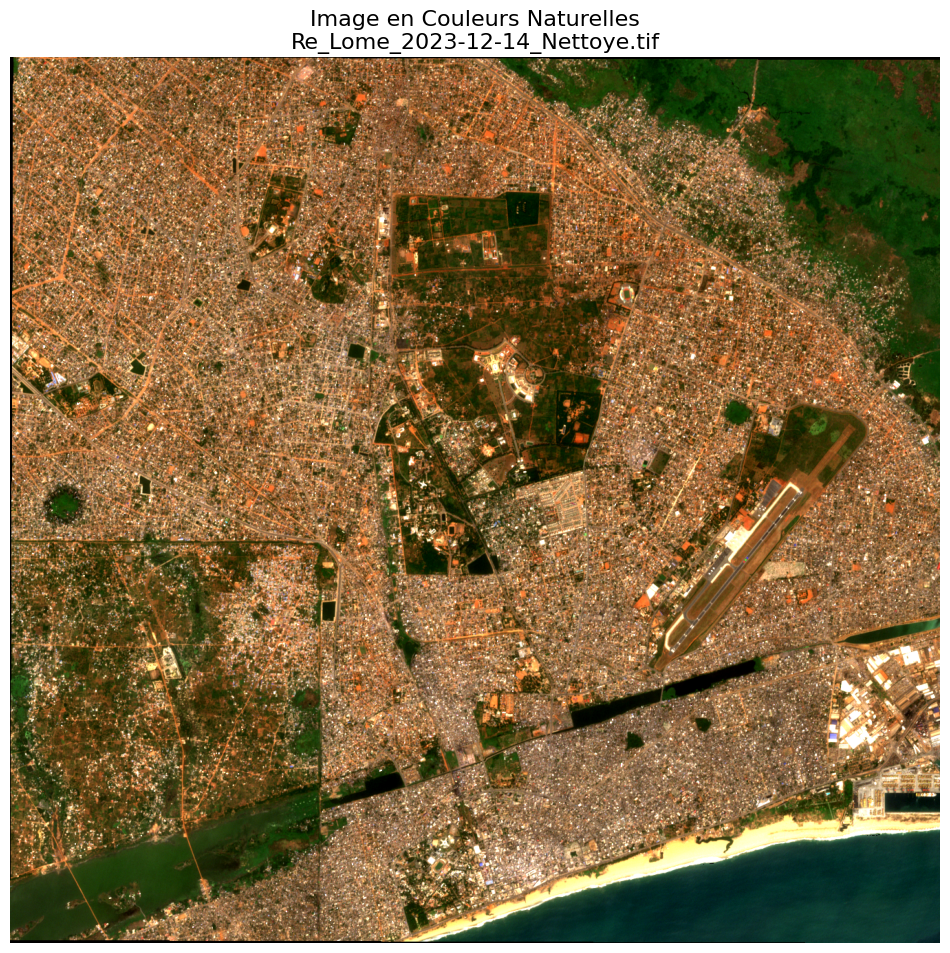

In [ ]:
#  EXEMPLE D'UTILISATION DE LA FONCTION

# Définissez le chemin vers le dossier où se trouvent vos images nettoyées
dossier_images = '/content/drive/My Drive/Export_Lome_Re'

# Choisissez le nom d'une image que vous avez exportée
nom_image = 'RLome_2023-12-14_Nettoye.tif' # Remplacez par un de vos noms de fichier

# Construire le chemin complet
chemin_image_a_tester = os.path.join(dossier_images, nom_image)

# Appeler la fonction !
afficher_images(chemin_image_a_tester)

# Vous pouvez facilement l'appeler pour une autre image
# nom_autre_image = 'Lome_2025-01-22_Nettoye.tif'
# chemin_autre_image = os.path.join(dossier_images, nom_autre_image)
# afficher_couleurs_naturelles(chemin_autre_image)

### **Analyse Radiométrique des Bandes Clés : Rouge et Proche-Infrarouge**

**1. Objectif**

Après le nettoyage complet de notre image Lome_2024-02-07_Nettoye.tif, il est essentiel de procéder à une analyse radiométrique pour comprendre la composition spectrale du paysage. Cette étape consiste à visualiser la distribution des valeurs de pixels (la réflectance) pour des bandes spectrales clés.

Nous avons choisi d'analyser en détail la Bande 4 (Rouge) et la Bande 8 (Proche-Infrarouge - NIR). Ces deux bandes sont fondamentales en télédétection car leur interaction est au cœur du calcul de l'indice de végétation (NDVI) et permet de discriminer efficacement les principales classes d'occupation du sol.

--- Génération des histogrammes d'analyse pour : Lome_2024-02-07_Nettoye.tif ---


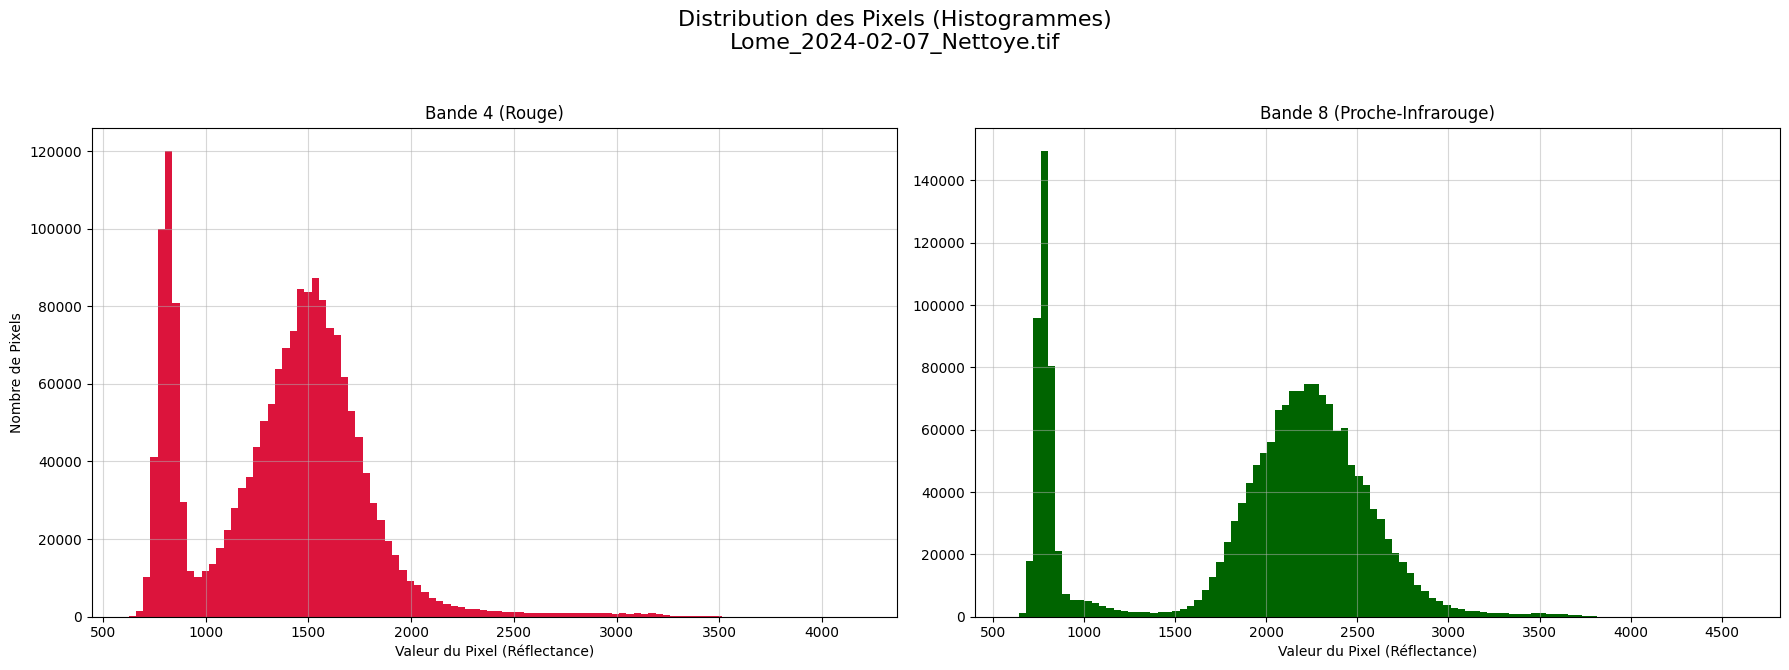

Observez le pic des valeurs sombres dans la bande 8 : c'est l'eau et la ville.
Un pic de valeurs plus claires dans la bande 8 indiquerait une forte présence de végétation.


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

def afficher_histogrammes_analyse(chemin_image_geotiff):
    """
    Ouvre une image nettoyée et affiche les histogrammes de deux bandes clés
    pour l'analyse : le Rouge (B4) et le Proche-Infrarouge (B8).
    """
    nom_fichier = os.path.basename(chemin_image_geotiff)
    print(f"--- Génération des histogrammes d'analyse pour : {nom_fichier} ---")

    try:
        with rasterio.open(chemin_image_geotiff) as src:
            # Lire la bande Rouge (B4, index 3) et Infrarouge (B8, index 4)
            b4_rouge = src.read(3).astype(float)
            b8_nir = src.read(4).astype(float)

            # On ne prend que les pixels utiles (différents de 0) pour l'histogramme
            b4_pixels_utiles = b4_rouge[b4_rouge != 0].flatten()
            b8_pixels_utiles = b8_nir[b8_nir != 0].flatten()

            # --- Affichage des histogrammes ---
            fig, axes = plt.subplots(1, 2, figsize=(18, 7))
            fig.suptitle(f"Distribution des Pixels (Histogrammes)\n{nom_fichier}", fontsize=16)

            # Histogramme de la bande Rouge (B4)
            axes[0].hist(b4_pixels_utiles, bins=100, color='crimson')
            axes[0].set_title('Bande 4 (Rouge)', fontsize=12)
            axes[0].set_xlabel('Valeur du Pixel (Réflectance)')
            axes[0].set_ylabel('Nombre de Pixels')
            axes[0].grid(True, alpha=0.5)

            # Histogramme de la bande Proche-Infrarouge (B8)
            axes[1].hist(b8_pixels_utiles, bins=100, color='darkgreen')
            axes[1].set_title('Bande 8 (Proche-Infrarouge)', fontsize=12)
            axes[1].set_xlabel('Valeur du Pixel (Réflectance)')
            axes[1].grid(True, alpha=0.5)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

            print("Observez le pic des valeurs sombres dans la bande 8 : c'est l'eau et la ville.")
            print("Un pic de valeurs plus claires dans la bande 8 indiquerait une forte présence de végétation.")

    except Exception as e:
        print(f"Une erreur est survenue : {e}")


# --- EXEMPLE D'UTILISATION ---
dossier_images = '/content/drive/My Drive/Export_Images_GEE_Nettoyees'
nom_image = 'Lome_2024-02-07_Nettoye.tif'
chemin_image = os.path.join(dossier_images, nom_image)

afficher_histogrammes_analyse(chemin_image)

## **Interprétons ensemble ce que cet histogramme nous révèle sur notre image :**

**1. Le Pic de Gauche (le « Gratte-ciel »)**

Ce que nous voyons : Nous avons un pic très haut et fin, positionné dans les valeurs de réflectance faibles (autour de 800). Cela nous indique qu'un grand nombre de pixels dans notre image absorbent la lumière rouge.
Ce que cela signifie pour nous :

**Quels sont les éléments qui absorbent la lumière rouge ?**

La Végétation Saine : C'est le point le plus important. Pour la photosynthèse, la chlorophylle absorbe très efficacement la lumière dans le spectre du rouge. Contrairement à l'infrarouge qu'elle réfléchit, la végétation "mange" la lumière rouge.

L'Eau : Comme pour l'infrarouge, l'eau continue d'absorber la lumière rouge et apparaît donc très sombre.

Notre conclusion : Ce pic à gauche est la signature combinée de « l'Eau + la Végétation ».

**2. Le Pic de Droite (la « Colline »)**

Ce que nous voyons : Nous observons une colline plus large, centrée sur des valeurs de réflectance plus élevées (autour de 1500).

Ce que cela signifie pour nous : Ce pic représente tout ce qui réfléchit bien la lumière rouge. Dans notre contexte urbain à Lomé, il s'agit principalement de :
Les Sols Nus et la Terre : Les sols, en particulier les sols riches en fer comme la latérite, sont de très bons réflecteurs de la lumière rouge.

Les Matériaux de Construction : De nombreux toits (béton, tuiles, tôle) et les routes réfléchissent plus la lumière rouge que la végétation.

Notre conclusion : Ce pic est la signature de notre environnement bâti et des sols nus. C'est ce qui donne à la ville cette couleur ocre/orangée dans l'image en couleurs naturelles.

**La Leçon la Plus Importante** : La Comparaison Rouge vs. Infrarouge

Mettons nos deux interprétations côte à côte :

Catégorie de Surface	Comportement dans le Proche-Infrarouge (B8)	Comportement dans le Rouge (B4)

Végétation	RÉFLÉCHIT (Pic de droite, valeurs ÉLEVÉES)	ABSORBE (Pic de gauche, valeurs FAIBLES)

Zone Urbaine / Sol Nu	ABSORBE (Pic de gauche, valeurs FAIBLES)	RÉFLÉCHIT (Pic de droite, valeurs ÉLEVÉES)

C'est la découverte fondamentale ! La végétation et le bâti ont des comportements diamétralement opposés dans ces deux bandes.

C'est précisément cette opposition que nous exploitons pour créer des indices comme le NDVI (Indice de Végétation par Différence Normalisée).

**La formule NDVI = (NIR - Rouge) / (NIR + Rouge)** est conçue pour maximiser cette différence :
Pour un pixel de végétation, le calcul sera (Valeur ÉLEVÉE - Valeur FAIBLE) / (Somme), ce qui donne un résultat élevé et positif.

Pour un pixel de ville, le calcul sera (Valeur FAIBLE - Valeur ÉLEVÉE) / (Somme), ce qui donne un résultat négatif ou proche de zéro.

## **Graphique 1 : Diagramme de Dispersion (Scatter Plot)**


**Méthodologie : Analyse par Diagramme de Dispersion**

Pour analyser la relation entre les bandes spectrales, nous avons généré un diagramme de dispersion (ou "scatter plot") en deux dimensions. Ce graphique permet de visualiser la distribution conjointe des valeurs de pixels entre deux bandes spectrales différentes.

Nous avons choisi de représenter la Bande 4 (Rouge) sur l'axe des abscisses et la Bande 8 (Proche-Infrarouge - NIR) sur l'axe des ordonnées. Ce choix est motivé par le fait que cette combinaison est particulièrement efficace pour discriminer les principales classes d'occupation du sol, notamment la végétation, l'eau et les surfaces minérales (sols nus, bâti).

Chaque point sur le graphique représente un pixel de l'image. Pour des raisons d'efficacité de calcul et de lisibilité, un échantillon aléatoire de 50 000 pixels a été extrait de l'image. La densité de ces points est représentée par un code couleur (carte de chaleur), où les couleurs chaudes indiquent une forte concentration de pixels ayant des caractéristiques spectrales similaires. L'analyse de la structure des nuages de points formés sur ce diagramme permet d'identifier les signatures spectrales dominantes et la séparabilité des différentes classes présentes dans la scène.

--- Génération du Diagramme de Dispersion pour : Lome_2024-02-07_Nettoye.tif ---


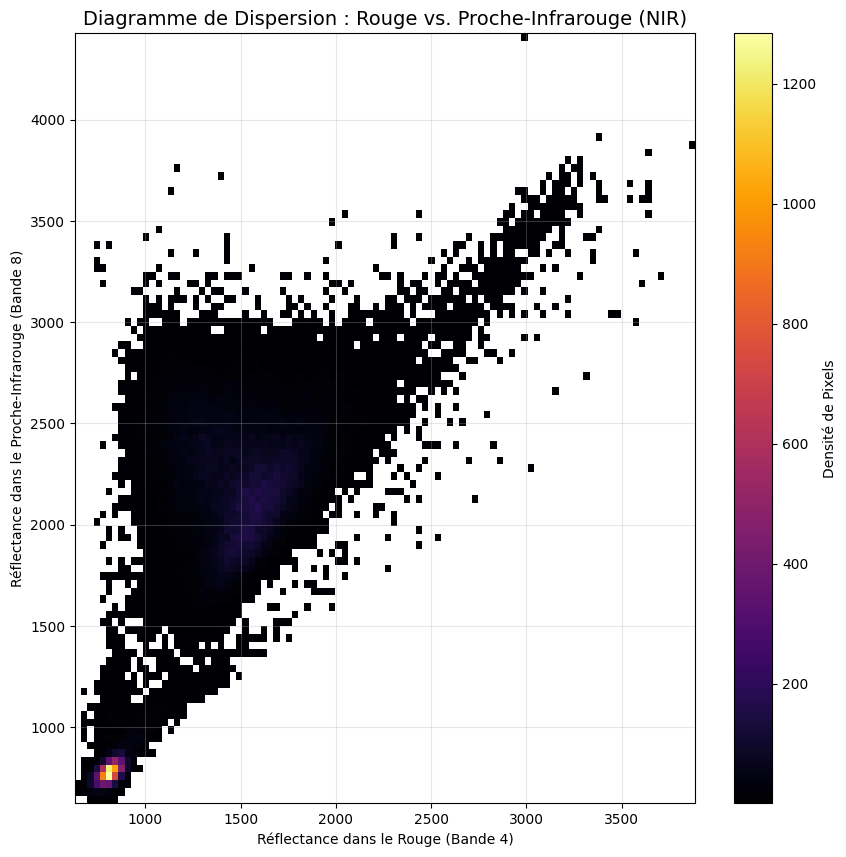

In [ ]:
def generer_diagramme_dispersion(chemin_image_geotiff, echantillon_taille=50000):
    """
    Génère un diagramme de dispersion (scatter plot) en 2D comparant les bandes
    Rouge (B4) et Proche-Infrarouge (NIR) d'une image.

    Args:
        chemin_image_geotiff (str): Chemin vers l'image à analyser.
        echantillon_taille (int): Nombre de pixels à échantillonner pour le graphique.
    """
    nom_fichier = os.path.basename(chemin_image_geotiff)
    print(f"--- Génération du Diagramme de Dispersion pour : {nom_fichier} ---")

    try:
        with rasterio.open(chemin_image_geotiff) as src:
            # Lire la bande Rouge (B4, supposée à l'indice 2) et NIR (B8, supposée à l'indice 3)
            # Rappel : les indices sont 0-based. B4 -> indice 2, B8 -> indice 3.
            # B1, B2, B3, B4, B5, B6, B7, B8, B8A... -> B4=indice3, B8=indice7
            # Assumons un ordre simple B2,B3,B4,B8,B11,B12 pour l'exemple. Adaptez si besoin.
            B4_IDX = 2
            B8_IDX = 3

            b4_rouge = src.read(B4_IDX + 1).astype(float)
            b8_nir = src.read(B8_IDX + 1).astype(float)

            # Masquer les pixels NoData (valeur 0)
            nodata_mask = (b4_rouge == 0)

            b4_valides = b4_rouge[~nodata_mask]
            b8_valides = b8_nir[~nodata_mask]

            # Prendre un échantillon aléatoire pour un affichage rapide
            if b4_valides.size > echantillon_taille:
                random_indices = np.random.choice(b4_valides.size, echantillon_taille, replace=False)
                x_samples = b4_valides.flatten()[random_indices]
                y_samples = b8_valides.flatten()[random_indices]
            else:
                x_samples = b4_valides.flatten()
                y_samples = b8_valides.flatten()

            # Utiliser hist2d pour visualiser la densité des points
            plt.figure(figsize=(10, 10))
            plt.hist2d(x_samples, y_samples, bins=100, cmap='inferno', cmin=1)
            plt.title('Diagramme de Dispersion : Rouge vs. Proche-Infrarouge (NIR)', fontsize=14)
            plt.xlabel('Réflectance dans le Rouge (Bande 4)')
            plt.ylabel('Réflectance dans le Proche-Infrarouge (Bande 8)')
            plt.colorbar(label='Densité de Pixels')
            plt.grid(True, alpha=0.3)
            plt.show()

    except Exception as e:
        print(f"Une erreur est survenue : {e}")

#  EXEMPLE D'UTILISATION
chemin_image = '/content/drive/My Drive/Export_Images_GEE_Nettoyees/Lome_2024-02-07_Nettoye.tif'
generer_diagramme_dispersion(chemin_image)



## *Interprétation Brève du Diagramme de Dispersion (Rouge vs. NIR)**

Ce diagramme de dispersion révèle la structure spectrale fondamentale du paysage de Lomé. La distribution des pixels forme une structure triangulaire classique, ce qui confirme la présence de trois principales classes d'occupation du sol distinctes et bien séparées :

**Le Point Chaud en Bas à Gauche (Eau et/ou Urbain Très Dense)** : Le point jaune vif, indiquant une très forte densité de pixels, est situé dans la zone de faible réflectance dans le Rouge ET de faible réflectance dans le Proche-Infrarouge. C'est la signature typique de l'eau, qui absorbe fortement la lumière dans ces deux longueurs d'onde. Cette zone inclut également probablement l'asphalte et les ombres profondes du tissu urbain très dense.

**La Ligne Diagonale (Sols Nus et Bâti)** : La concentration principale de points s'étire le long d'une diagonale. Cela représente les surfaces où la réflectance dans le Rouge et le Proche-Infrarouge augmente de manière corrélée. C'est la "ligne des sols", caractéristique des surfaces minérales comme les sols nus, le sable, et la majorité des matériaux de construction (bâti).

**La Dispersion vers le Haut (Végétation)** : Les points qui s'échappent de la diagonale et montent verticalement vers le haut du graphique sont ceux qui ont une faible réflectance dans le Rouge (absorption par la chlorophylle) et une forte réflectance dans le Proche-Infrarouge (réflexion par la structure cellulaire des feuilles). Ce sont sans équivoque les pixels de végétation. Le fait qu'ils soient dispersés et moins concentrés que l'eau suggère une végétation hétérogène, typique des parcs urbains, des jardins et des zones agricoles périurbaines.

En conclusion, ce graphique est une excellente nouvelle : il démontre que les principales classes d'occupation du sol de votre zone d'étude sont spectralement bien séparables. Cette distinction claire entre l'eau/urbain dense, le bâti/sol nu, et la végétation est une base très solide qui prédit un grand succès pour les étapes de classification futures.


### **Graphique 2 : Profils Spectraux Moyens**


**Méthodologie : Analyse par Profils Spectraux**

Pour caractériser les principales classes d'occupation du sol présentes dans l'image, nous avons tracé leurs **profils spectraux moyens**. Un profil spectral est une "signature" qui représente la réflectance d'une surface à travers les différentes longueurs d'onde (les bandes spectrales).

N'ayant pas de données de terrain pour définir manuellement des zones d'entraînement, nous avons employé une approche non-supervisée pour identifier les regroupements spectraux naturels au sein de l'image. Une méthode de **classification par clustering (K-Means)** a été appliquée à l'ensemble des pixels valides de l'image, en utilisant toutes les bandes spectrales disponibles. Nous avons paramétré l'algorithme pour identifier les trois classes spectrales les plus distinctes.

Pour chaque classe ainsi détectée, le profil spectral moyen a été calculé en moyennant les valeurs de réflectance de tous les pixels appartenant à cette classe, pour chaque bande. La superposition de ces profils sur un même graphique permet de visualiser et de quantifier les différences de comportement spectral entre les classes, et ainsi d'inférer leur nature probable (ex: végétation, eau/ombre, sol nu/bâti).




--- Génération des Profils Spectraux pour : Lome_2024-02-07_Nettoye.tif ---
  Classification non-supervisée (K-Means) en cours...


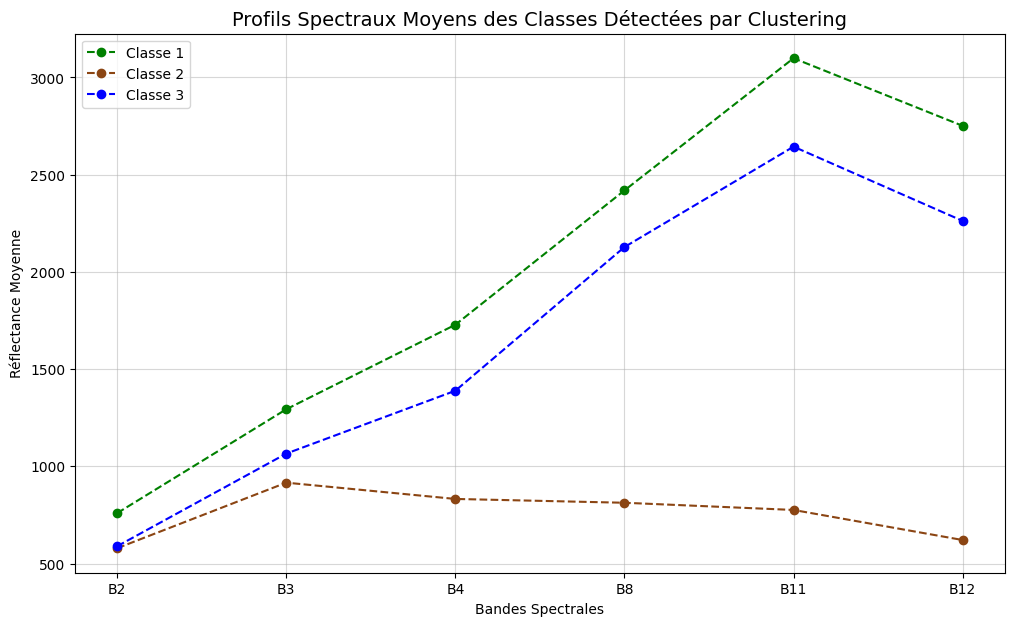

In [ ]:
def generer_profils_spectraux(chemin_image_geotiff, nombre_de_classes=3):
    """
    Génère les profils spectraux moyens des classes détectées par clustering
    dans une image multibande.

    Args:
        chemin_image_geotiff (str): Chemin vers l'image à analyser.
        nombre_de_classes (int): Nombre de classes à identifier.
    """
    nom_fichier = os.path.basename(chemin_image_geotiff)
    print(f"\n--- Génération des Profils Spectraux pour : {nom_fichier} ---")

    try:
        with rasterio.open(chemin_image_geotiff) as src:
            # Noms des bandes pour l'affichage (à adapter si vos bandes sont différentes)
            band_names = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
            if src.count != len(band_names):
                band_names = [f'Bande {i+1}' for i in range(src.count)]

            # Lire toutes les bandes
            all_bands = src.read().astype(float)

            # Préparer les données pour le clustering
            # 1. Masquer les pixels NoData (valeur 0)
            nodata_mask = (all_bands[0] == 0)
            all_bands_masked = np.ma.masked_array(all_bands, mask=np.stack([nodata_mask] * src.count))

            # 2. Mettre les données sous la forme d'une liste de pixels : (nb_pixels, nb_bandes)
            pixels_pour_clustering = all_bands_masked.reshape(src.count, -1).T.compressed().reshape(-1, src.count)

            # Pour la rapidité, on peut prendre un échantillon si l'image est très grande
            if pixels_pour_clustering.shape[0] > 200000:
                indices = np.random.choice(pixels_pour_clustering.shape[0], 200000, replace=False)
                pixels_echantillon = pixels_pour_clustering[indices]
            else:
                pixels_echantillon = pixels_pour_clustering

            # Appliquer un clustering K-Means pour trouver les classes
            print("  Classification non-supervisée (K-Means) en cours...")
            kmeans = MiniBatchKMeans(n_clusters=nombre_de_classes, random_state=42, n_init='auto', batch_size=4096).fit(pixels_echantillon)

            # Calculer le profil spectral moyen pour chaque classe
            mean_profiles = []
            for i in range(nombre_de_classes):
                # Utiliser les labels du clustering pour sélectionner les pixels de chaque classe
                mean_profiles.append(pixels_echantillon[kmeans.labels_ == i].mean(axis=0))

            # Afficher les profils spectraux
            plt.figure(figsize=(12, 7))
            colors = ['green', 'saddlebrown', 'blue', 'grey', 'orange']
            labels = [f'Classe {i+1}' for i in range(nombre_de_classes)]

            for i, profile in enumerate(mean_profiles):
                plt.plot(band_names, profile, marker='o', linestyle='--', color=colors[i], label=labels[i])

            plt.title('Profils Spectraux Moyens des Classes Détectées par Clustering', fontsize=14)
            plt.xlabel('Bandes Spectrales')
            plt.ylabel('Réflectance Moyenne')
            plt.legend()
            plt.grid(True, alpha=0.5)
            plt.show()

    except Exception as e:
        print(f"Une erreur est survenue : {e}")

# --- EXEMPLE D'UTILISATION ---
chemin_image = '/content/drive/My Drive/Export_Images_GEE_Nettoyees/Lome_2024-02-07_Nettoye.tif'
generer_profils_spectraux(chemin_image, nombre_de_classes=3)

## **Interprétation Brève des Profils Spectraux**

Ce graphique est une excellente confirmation du succès de la classification non-supervisée. Il a réussi à identifier et à séparer les trois principales "empreintes digitales" spectrales du paysage de Lomé. Chaque ligne représente le comportement moyen d'une classe face à la lumière, à travers les différentes bandes de Sentinel-2 :

**Classe 1 (Ligne Verte - Végétation)** : Cette signature est caractéristique de la végétation saine. On observe une faible réflectance dans le Rouge (B4) due à l'absorption par la chlorophylle, suivie d'un pic très élevé dans le Proche-Infrarouge (B8), causé par la réflexion de la lumière sur la structure cellulaire des feuilles. C'est la signature la plus nette et la plus facile à identifier.

**Classe 2 (Ligne Marron - Eau et/ou Ombres)** : Cette classe a une réflectance très faible sur l'ensemble du spectre. C'est la signature typique de l'eau, qui absorbe la majorité de la lumière, en particulier dans les longueurs d'onde infrarouges (B8, B11, B12). Cette classe peut également inclure les ombres profondes des grands bâtiments ou du relief.

**Classe 3 (Ligne Bleue - Bâti et Sols Nus)** : Cette signature, qui augmente progressivement du visible (B2) vers le proche-infrarouge (B8) avant de redescendre, est typique des surfaces minérales et artificielles. Elle représente le mélange de sols nus, de routes, et de matériaux de construction (le bâti). Elle se distingue de la végétation par l'absence de pic marqué en B8.

**Conclusion** : L'algorithme a parfaitement réussi à séparer les composantes fondamentales du paysage : la végétation, l'eau/les ombres, et le bâti/sol nu. La grande distinction entre ces trois profils spectraux est une excellente nouvelle, car elle confirme que ces classes peuvent être cartographiées avec une grande précision lors de l'étape de classification finale.

In [ ]:
# Chemin vers les impages
image_folder = '/content/drive/My Drive/Export_Lome_Serie_Temporelle'

# Verifier si le repertoire 'image_folder' existe, si oui affiche toutes les images
if os.path.exists(image_folder):
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.tif')]

    print("Images chargées :")
    for f in image_files:
        print(f)
else:
    print(f"The directory {image_folder} does not exist. Please ensure the export tasks are complete and Google Drive is mounted correctly.")

Images chargées :
/content/drive/My Drive/Export_Lome_Serie_Temporelle/Lome_2023-12-14_Nettoye.tif
/content/drive/My Drive/Export_Lome_Serie_Temporelle/Lome_2024-02-07_Nettoye.tif
/content/drive/My Drive/Export_Lome_Serie_Temporelle/Lome_2018-12-25_Nettoye.tif


## **Méthodologie : Extraction de Caractéristiques pour l'Analyse de l'Urbanisation**

**Objectif**

Afin de quantifier l'évolution du paysage urbain, nous devons transformer les données radiométriques brutes de nos images en indicateurs quantitatifs significatifs. L'objectif de cette étape est d'extraire, pour chaque image de notre série temporelle, un ensemble de caractéristiques spectrales spécifiquement choisies pour leur capacité à discriminer les surfaces urbaines, la végétation et les sols nus.
Méthode : Calcul d'Indices Spectraux

Nous avons appliqué une méthode d'extraction de caractéristiques basée sur le calcul de trois indices spectraux reconnus pour leur pertinence dans les études d'urbanisation. Pour chaque image de notre jeu de données final (aligné, nettoyé et débruité), la valeur moyenne de chaque indice a été calculée en ignorant les pixels NoData.

Les indices retenus sont :

**NDVI (Normalized Difference Vegetation Index)** : L'indice de végétation par différence normalisée est utilisé comme indicateur principal de la santé et de la densité de la végétation. Une diminution de sa valeur moyenne au fil du temps est un marqueur indirect de l'urbanisation, signalant la conversion de zones végétalisées en surfaces artificielles.

**NDBI (Normalized Difference Built-up Index)** : L'indice du bâti par différence normalisée est notre indicateur direct des zones construites. Il exploite la réflectance élevée des matériaux artificiels dans l'infrarouge à ondes courtes (SWIR). Une augmentation de sa valeur moyenne signale une densification ou une expansion du tissu urbain.

**BSI (Bare Soil Index)** : L'indice de sol nu est utilisé pour détecter les surfaces de terre, de sable ou les zones en chantier. L'augmentation de cet indice peut indiquer une phase de défrichage ou de terrassement, souvent précurseur à la construction, fournissant ainsi une information complémentaire sur la dynamique de l'urbanisation.

In [ ]:

liste_images_a_analyser = [
      '/content/drive/My Drive/Export_Lome_Serie_Temporelle/Lome_2023-12-14_Nettoye.tif',
      '/content/drive/My Drive/Export_Lome_Serie_Temporelle/Lome_2024-02-07_Nettoye.tif',
      '/content/drive/My Drive/Export_Lome_Serie_Temporelle/Lome_2018-12-25_Nettoye.tif'
]


INDICES_BANDES = {
    'blue': 0,    # Bande Bleue (B2)
    'green': 1,   # Bande Verte (B3)
    'red': 2,     # Bande Rouge (B4)
    'nir': 3,     # Proche-Infrarouge (B8)
    'swir1': 4,   # SWIR 1 (B11)
    'swir2': 5    # SWIR 2 (B12)
}


def extraire_toutes_caracteristiques(image_path, band_indices_config):
    """
    Ouvre une image, en extrait des caractéristiques spectrales, texturales et
    d'ondelettes, et les retourne dans un dictionnaire.
    """
    nom_fichier = os.path.basename(image_path)
    print(f"  Analyse de : {nom_fichier}")

    features = {"Nom du Fichier": nom_fichier}

    try:
        with rasterio.open(image_path) as src:
            # Lire les bandes nécessaires en float pour les calculs
            blue = src.read(band_indices_config['blue'] + 1).astype(np.float32)
            green = src.read(band_indices_config['green'] + 1).astype(np.float32)
            red = src.read(band_indices_config['red'] + 1).astype(np.float32)
            nir = src.read(band_indices_config['nir'] + 1).astype(np.float32)
            swir1 = src.read(band_indices_config['swir1'] + 1).astype(np.float32)

            # Créer un masque NoData (pixels à 0), essentiel pour des stats correctes
            nodata_mask = (blue == 0)

            # . Caractéristiques Spectrales (Indices)
            with np.errstate(divide='ignore', invalid='ignore'):
                # NDVI
                ndvi = np.nan_to_num((nir - red) / (nir + red))
                # NDWI (McFeeters, pour l'eau)
                ndwi = np.nan_to_num((green - nir) / (green + nir))
                # NDBI (Bâti)
                ndbi = np.nan_to_num((swir1 - nir) / (swir1 + nir))
                # BSI (Sol Nu)
                bsi_num = (swir1 + red) - (nir + blue)
                bsi_den = (swir1 + red) + (nir + blue)
                bsi = np.nan_to_num(bsi_num / bsi_den)

            # Calcul des statistiques moyennes en ignorant le NoData
            features['NDVI_moyen'] = np.mean(ndvi[~nodata_mask])
            features['NDWI_moyen'] = np.mean(ndwi[~nodata_mask])
            features['NDBI_moyen'] = np.mean(ndbi[~nodata_mask])
            features['BSI_moyen'] = np.mean(bsi[~nodata_mask])

            #  Caractéristiques Texturales (GLCM)
            # On calcule la texture sur la bande NIR qui a un bon contraste
            nir_band_valide = nir[~nodata_mask]
            if nir_band_valide.size > 0:
                # Normaliser la bande NIR valide à 0-255 pour GLCM
                min_val, max_val = np.min(nir_band_valide), np.max(nir_band_valide)
                nir_rescaled = np.zeros_like(nir, dtype=np.uint8)
                if (max_val - min_val) > 0:
                    nir_rescaled[~nodata_mask] = (255 * (nir_band_valide - min_val) / (max_val - min_val)).astype(np.uint8)

                # Calculer GLCM seulement sur la zone valide
                glcm = graycomatrix(nir_rescaled, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

                features['Texture_Contraste'] = graycoprops(glcm, 'contrast')[0, 0]
                features['Texture_Homogeneite'] = graycoprops(glcm, 'homogeneity')[0, 0]
                features['Texture_Energie'] = graycoprops(glcm, 'energy')[0, 0]
                features['Texture_Correlation'] = graycoprops(glcm, 'correlation')[0, 0]

            #  Caractéristiques d'Ondelettes
            # Appliquer la décomposition sur la bande NIR
            coeffs = pywt.dwt2(nir, 'db4')
            cA, (cH, cV, cD) = coeffs

            features['Ondelette_Energie_H'] = np.mean(np.square(cH))
            features['Ondelette_Energie_V'] = np.mean(np.square(cV))
            features['Ondelette_Energie_D'] = np.mean(np.square(cD))

        return features

    except Exception as e:
        print(f"     ERREUR lors de l'extraction sur {os.path.basename(image_path)} : {e}")
        return None


In [ ]:
def analyser_toutes_images(liste_chemins, config_indices):
    """
    Orchestre l'extraction de toutes les caractéristiques pour une liste d'images.
    """
    print(f"--- Lancement de l'Extraction Complète des Caractéristiques ---")

    all_features_list = []
    for path in liste_chemins:
        features = extraire_toutes_caracteristiques(path, config_indices)
        if features:
            all_features_list.append(features)

    if all_features_list:
        df_final_features = pd.DataFrame(all_features_list)
        return df_final_features.round(4)
    else:
        return None

#  LANCEMENT DU PROCESSUS
df_resultats_complets = analyser_toutes_images(liste_images_a_analyser, INDICES_BANDES)

# Afficher le tableau de résultats final
if df_resultats_complets is not None:
    print("\n--- Tableau Final des Caractéristiques Extraites ---")
    print(df_resultats_complets)
else:
    print("\n--- Aucune caractéristique n'a pu être extraite. ---")

--- Lancement de l'Extraction Complète des Caractéristiques ---
  Analyse de : Lome_2023-12-14_Nettoye.tif
  Analyse de : Lome_2024-02-07_Nettoye.tif
  Analyse de : Lome_2018-12-25_Nettoye.tif

--- Tableau Final des Caractéristiques Extraites ---
                Nom du Fichier  NDVI_moyen  NDWI_moyen  NDBI_moyen  BSI_moyen  \
0  Lome_2023-12-14_Nettoye.tif      0.2773     -0.3326      0.0563     0.0930   
1  Lome_2024-02-07_Nettoye.tif      0.1438     -0.2319      0.0824     0.1702   
2  Lome_2018-12-25_Nettoye.tif      0.0758     -0.0806      0.0009     0.0289   

   Texture_Contraste  Texture_Homogeneite  Texture_Energie  \
0            26.7892               0.5258           0.3675   
1           652.4181               0.4351           0.3285   
2           201.4903               0.6286           0.4109   

   Texture_Correlation  Ondelette_Energie_H  Ondelette_Energie_V  \
0               0.9451         18390.103516         21833.689453   
1               0.8819         60183.898438

In [ ]:
df_resultats_complets

Nom du Fichier  NDVI_moyen  NDWI_moyen  NDBI_moyen  BSI_moyen  \
0  Lome_2023-12-14_Nettoye.tif      0.2773     -0.3326      0.0563     0.0930   
1  Lome_2024-02-07_Nettoye.tif      0.1438     -0.2319      0.0824     0.1702   
2  Lome_2018-12-25_Nettoye.tif      0.0758     -0.0806      0.0009     0.0289   

   Texture_Contraste  Texture_Homogeneite  Texture_Energie  \
0            26.7892               0.5258           0.3675   
1           652.4181               0.4351           0.3285   
2           201.4903               0.6286           0.4109   

   Texture_Correlation  Ondelette_Energie_H  Ondelette_Energie_V  \
0               0.9451         18390.103516         21833.689453   
1               0.8819         60183.898438         67904.304688   
2               0.8105         98222.015625        107278.617188   

   Ondelette_Energie_D  
0          3145.658691  
1         41857.875000  
2         69806.015625

In [ ]:
df_resultats_complets.head()

In [ ]:
df_resultats_complets.to_csv('/content/drive/My Drive/Analyse_Changements/donnees_caracteristiques.csv', index=False)

In [ ]:
#CONFIGURATION UTILISATEUR (LA SEULE PARTIE À MODIFIER)

chemin_image_ancienne = '/content/drive/My Drive/Export_Lome_Serie_Temporelle/Lome_20218-12-25_Nettoye.tif'


chemin_image_recente = '/content/drive/My Drive/Export_Lome_Serie_Temporelle/aligned_Lome_2025-05-12.tif'


#  VÉRIFIER ET ADAPTER LES INDICES (0-based) DE VOS BANDES
INDICES_BANDES = {
    'nir': 3,     # Proche-Infrarouge (B8)
    'swir1': 4,   # SWIR 1 (B11)
}

#  SPÉCIFIER LE FICHIER DE SORTIE POUR LA CARTE DE CHANGEMENT
dossier_sortie_analyse = '/content/drive/My Drive/Analyse_Changements'
os.makedirs(dossier_sortie_analyse, exist_ok=True)
chemin_carte_changement = os.path.join(dossier_sortie_analyse, 'carte_changement_NDBI_2018-2025.tif')

# ONCTION DE CALCUL ET DE VISUALISATION


def creer_carte_changement_ndbi(path_ancienne, path_recente, band_indices_config, output_path):
    """
    Crée une carte de changement en calculant la différence des indices NDBI
    entre une image ancienne et une image récente.

    Args:
        path_ancienne (str): Chemin vers l'image la plus ancienne.
        path_recente (str): Chemin vers l'image la plus récente.
        band_indices_config (dict): Dictionnaire des indices des bandes NIR et SWIR1.
        output_path (str): Chemin où sauvegarder la carte de changement.
    """
    print("--- Création de la Carte de Changement NDBI ---")

    try:
        # --- Fonction interne pour calculer la carte NDBI d'une image ---
        def calculer_ndbi(image_path, indices):
            with rasterio.open(image_path) as src:
                # Lire les bandes nécessaires
                nir = src.read(indices['nir'] + 1).astype(np.float32)
                swir1 = src.read(indices['swir1'] + 1).astype(np.float32)

                # Calculer l'indice en ignorant les erreurs de division
                with np.errstate(divide='ignore', invalid='ignore'):
                    ndbi = (swir1 - nir) / (swir1 + nir)

                # Remplacer les NaN/inf par 0 et retourner le profil de l'image
                return np.nan_to_num(ndbi), src.profile

        # --- 1. Calculer la carte NDBI pour chaque date ---
        print("  Calcul du NDBI pour l'image ancienne...")
        ndbi_ancienne, profile = calculer_ndbi(path_ancienne, band_indices_config)

        print("  Calcul du NDBI pour l'image récente...")
        ndbi_recente, _ = calculer_ndbi(path_recente, band_indices_config)

        # --- 2. Soustraire les cartes pour obtenir le changement ---
        print("  Calcul de la différence...")
        carte_changement = ndbi_recente - ndbi_ancienne

        # Masquer les zones NoData (où l'image originale était à 0)
        with rasterio.open(path_ancienne) as src:
            nodata_mask = src.read(1) == 0
            carte_changement[nodata_mask] = -9999 # Utiliser une valeur NoData distincte

        # --- 3. Sauvegarder la carte de changement ---
        profile.update({
            'dtype': 'float32',
            'count': 1,
            'nodata': -9999
        })
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(carte_changement, 1)
        print(f"  -> Carte de changement sauvegardée sous : {os.path.basename(output_path)}")

        # --- 4. Visualiser le résultat ---
        plt.figure(figsize=(15, 15))

        # Utiliser une palette de couleurs divergente :
        # Rouge pour les changements positifs (urbanisation), Bleu pour les négatifs.
        # Le centre (autour de 0) sera blanc/gris.
        # vmin et vmax centrent la palette sur 0.
        plt.imshow(carte_changement, cmap='RdBu', vmin=-0.5, vmax=0.5)

        plt.colorbar(label='Changement de NDBI (Positif = Urbanisation)')
        plt.title(f'Carte de Changement du Bâti (NDBI)\n{os.path.basename(path_ancienne)} vs. {os.path.basename(path_recente)}', fontsize=16)
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Une erreur est survenue : {e}")


creer_carte_changement_ndbi(chemin_image_ancienne, chemin_image_recente, INDICES_BANDES, chemin_carte_changement)

--- Création de la Carte de Changement NDBI ---
  Calcul du NDBI pour l'image ancienne...
Une erreur est survenue : /content/drive/My Drive/Export_Lome_Serie_Temporelle/Lome_20218-12-25_Nettoye.tif: No such file or directory
